# Setup

In [1]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [2]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [3]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [4]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [5]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [6]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [7]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [8]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [9]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 181 MMcf
Total peak months intake from pipeline: 12,428 MMcf
Total intake from CaLNG: 1,288 MMcf
---
Total amount paid to pipeline: $18,463,575
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $28,123,575
Savings from using CaLNG: $12,080,986
---
Total cost if average draw daily: $15,342,871


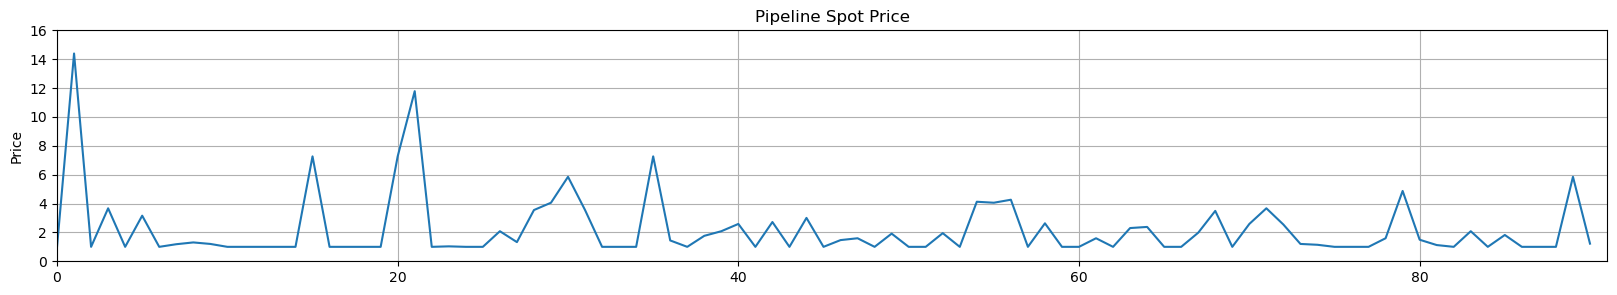

In [10]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

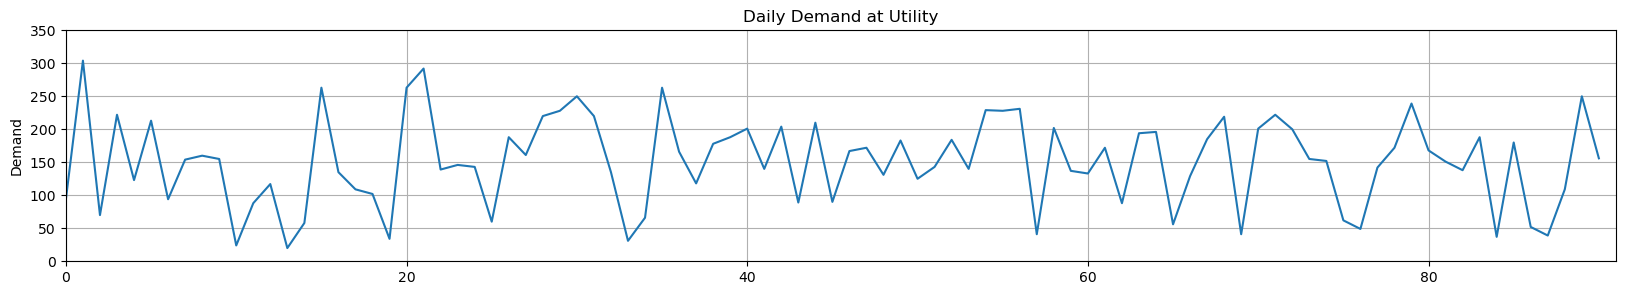

In [11]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

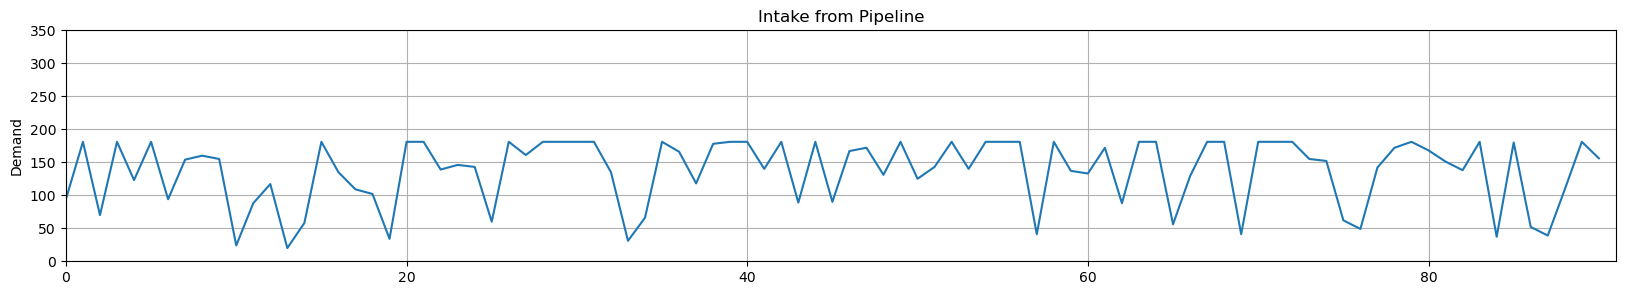

In [12]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

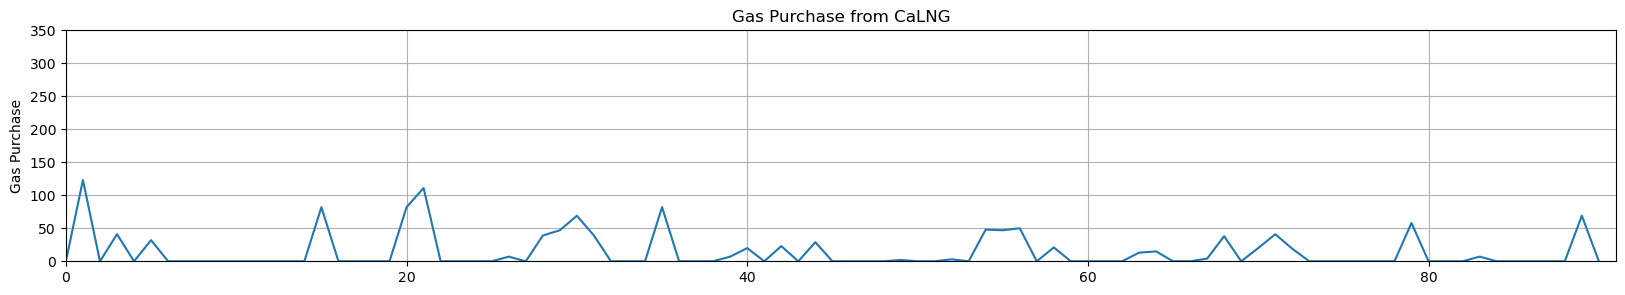

In [13]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

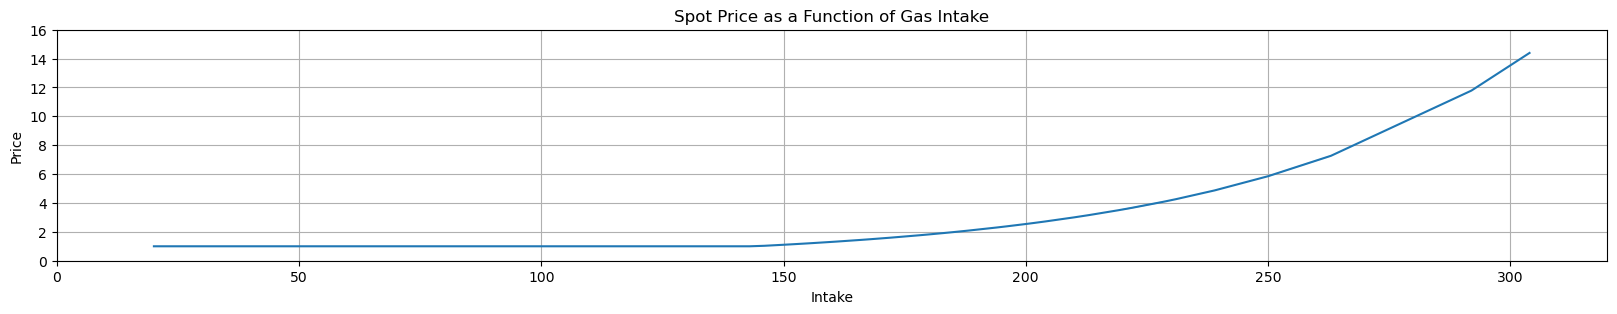

In [14]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

# Option

In [15]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [16]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 13,217 MMcf
Total intake from CaLNG: 1,144 MMcf
---
Total amount paid to pipeline: $19,341,389
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $28,341,389
Savings from using CaLNG: $10,517,360
---
Total cost if average draw daily: $18,078,728


# Option Optimization: find the optimal pair of (total_LNG) and (peak_intake_from_pipeline) that minimizes the expected cost per season.

In [17]:
import numpy as np
import pandas as pd

# Number of simulation draws per scenario
num_draws = 5000

# set the parameters and Decision variable ranges
total_lng_range = np.arange(700, 1300, 50)  # MMcf
peak_intake_from_pipeline_range = np.arange(170, 200, 5)  # MMcf

# Generate demand samples in bulk
sim_demand_matrix = np.random.normal(mean_daily_demand, std_dev_daily_demand, (num_draws, len(demand_data)))
sim_demand_matrix = np.clip(np.round(sim_demand_matrix), 0, None)  # Remove negative values

# Preallocate results
results = np.zeros((len(total_lng_range), len(peak_intake_from_pipeline_range)))

# Vectorized processing over total LNG and peak intake
for i, total_LNG in enumerate(total_lng_range):
    for j, peak_intake in enumerate(peak_intake_from_pipeline_range):

        # Process all simulations in a vectorized manner
        sim_usage_data_list = [
            determine_actual_usage(pd.DataFrame({'Demand': sim_demand_matrix[n]}), calng_price, peak_intake, total_LNG)
            for n in range(num_draws)
        ]

        # Extract cost statistics
        costs = np.array([
            calculate_cost_statistics(sim_usage_data, calng_price, peak_intake, total_LNG, return_data=True)["total_utility_cost"]
            for sim_usage_data in sim_usage_data_list
        ])

        # Store average cost for this configuration
        results[i, j] = np.mean(costs)

# Convert results to a DataFrame
df_results = pd.DataFrame(results, index=total_lng_range, columns=peak_intake_from_pipeline_range)

# Find the optimal (Total_LNG, Peak_Intake) combination
min_cost_idx = np.unravel_index(np.argmin(results), results.shape)
best_total_LNG = total_lng_range[min_cost_idx[0]]
best_peak_intake = peak_intake_from_pipeline_range[min_cost_idx[1]]
best_cost = results[min_cost_idx]

# Print best solution
print(f"Optimal Total LNG: {best_total_LNG:.0f} MMcf")
print(f"Optimal Peak Intake from Pipeline: {best_peak_intake:.0f} MMcf")
print(f"Minimum Expected Cost: ${best_cost / 1_000_000:,.2f} million")

Optimal Total LNG: 900 MMcf
Optimal Peak Intake from Pipeline: 180 MMcf
Minimum Expected Cost: $25.17 million


# Q2.1 - Plot Y: Average cost (with +/- 1 st dev band), X: total_LNG, given that peak_intake_from_pipeline is set to its optimum.

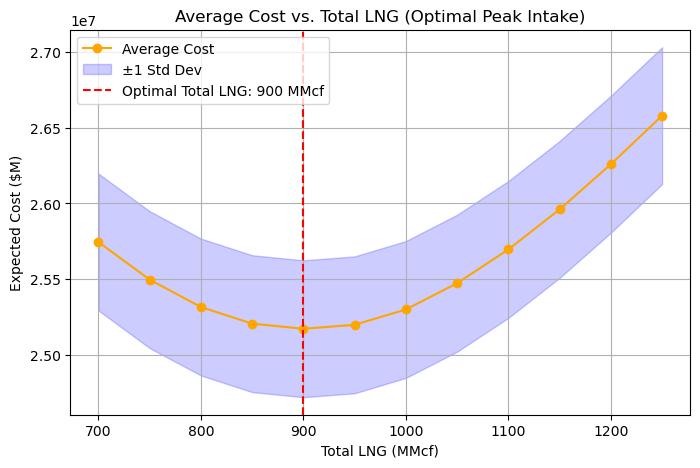

In [20]:
import matplotlib.pyplot as plt

# Use previously computed optimal values
optimal_total_LNG = 900
optimal_peak_intake = 180

# Extract data for plotting
total_LNG_data = df_results.loc[:, optimal_peak_intake]  # Fix peak intake at optimal value
peak_intake_data = df_results.loc[optimal_total_LNG, :]  # Fix total LNG at optimal value

# Compute standard deviations
std_total_LNG = total_LNG_data.std()
std_peak_intake = peak_intake_data.std()

# Plot 1: Cost vs. Total LNG (Fixed Peak Intake)
plt.figure(figsize=(8, 5))
plt.plot(total_LNG_data.index, total_LNG_data.values, marker='o', linestyle='-', label='Average Cost', color='orange')
plt.fill_between(total_LNG_data.index,
                 total_LNG_data.values - std_total_LNG,
                 total_LNG_data.values + std_total_LNG,
                 color='blue', alpha=0.2, label='±1 Std Dev')
plt.axvline(optimal_total_LNG, color='r', linestyle='--', label=f'Optimal Total LNG: {optimal_total_LNG} MMcf')
plt.xlabel("Total LNG (MMcf)")
plt.ylabel("Expected Cost ($M)")
plt.title("Average Cost vs. Total LNG (Optimal Peak Intake)")
plt.legend()
plt.grid()
plt.show()


# Q2.2 - Plot Y: Average cost (with +/- 1 st dev band), X: peak_intake_from_pipeline, given that total_LNG is set to its optimum.

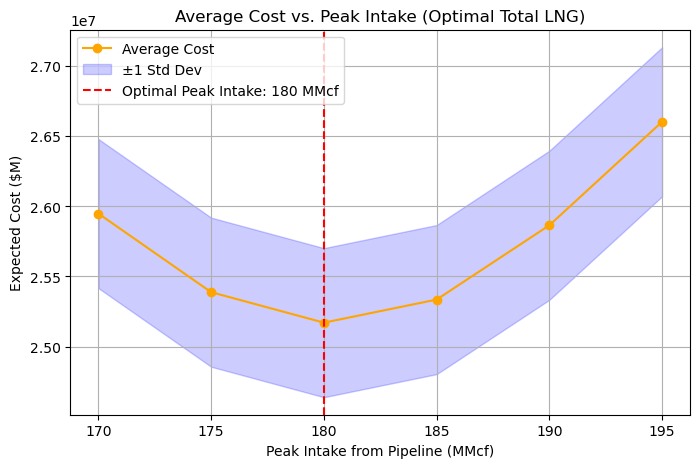

In [21]:
# Plot 2: Cost vs. Peak Intake (Fixed Total LNG)
plt.figure(figsize=(8, 5))
plt.plot(peak_intake_data.index, peak_intake_data.values, marker='o', linestyle='-', label='Average Cost', color='orange')
plt.fill_between(peak_intake_data.index,
                 peak_intake_data.values - std_peak_intake,
                 peak_intake_data.values + std_peak_intake,
                 color='blue', alpha=0.2, label='±1 Std Dev')
plt.axvline(optimal_peak_intake, color='r', linestyle='--', label=f'Optimal Peak Intake: {optimal_peak_intake} MMcf')
plt.xlabel("Peak Intake from Pipeline (MMcf)")
plt.ylabel("Expected Cost ($M)")
plt.title("Average Cost vs. Peak Intake (Optimal Total LNG)")
plt.legend()
plt.grid()
plt.show()